In [13]:

from user_args import UARGS, load_parser, check_args
from br_stat_profiler import preprocess_recal_table, profile_rt

RECAL_TABLE_DIR = "./data/test_bqsr/"
REC_TAB_FULL_PATH = \
    RECAL_TABLE_DIR + "pre-LUAD-02_all_chrs_wo_Y_MT.bam.context4.recal_data.table"
OUTFILE_DIR = "./outfiles/"
OUTFILE = OUTFILE_DIR + "first_profile.csv"
import os
from os.path import exists

if os.path.exists(OUTFILE):
    os.remove(OUTFILE)

cmd = f"--infile {REC_TAB_FULL_PATH} -o {OUTFILE}"

parser = load_parser()
args = parser.parse_args(cmd.split())
adict = check_args(args) 
# [print(key,":",val) for key,val in adict.items()] 
  
rt2_pre_stat_df = preprocess_recal_table(adict)
rt2_pre_stat_df
profile = profile_rt(rt2_pre_stat_df, adict)
profile.head()


harvested completed: Arguments
harvested completed: Quantized
harvested completed: RecalTable0
harvested completed: RecalTable1
harvested completed: RecalTable2


,HVWKMCCXY
QErrWeightedAvg:AAAA:0:Context,-1.009847
QErrWeightedAvg:AAAA:1:Context,-0.862207
QErrWeightedAvg:AAAA:2:Context,-1.009847
QErrWeightedAvg:AAAA:3:Context,0.950003
QErrWeightedAvg:AAAC:0:Context,-0.806285


In [14]:
from br_stat_profiler import save_profile
# testing the concatenation feature
# profile = profile.rename(columns={'HVWKMCCXY':'new'}) 
save_profile(profile, adict)

In [16]:
from br_stat_profiler import prepare_stat_df
from constants import RC_TAB2
mode = RC_TAB2.CNTXT_COV
cntxt_rt2_stat_df = prepare_stat_df(rt2_pre_stat_df, mode, adict)
cntxt_rt2_stat_df

,ReadGroup,RG_ScoreBin,Context,QErrAvg,RG_ScrBin_COV_N,RG_ScrBin_N,QErrWeightedAvg,ID
0,HVWKMCCXY,0,AAAA,0.000000,3,1159,0.000000,AAAA:0:Context
256,HVWKMCCXY,1,AAAA,0.400000,5,1598,0.001252,AAAA:1:Context
512,HVWKMCCXY,2,AAAA,0.000000,7,1792,0.000000,AAAA:2:Context
768,HVWKMCCXY,3,AAAA,3.500000,6,1264,0.016614,AAAA:3:Context
1,HVWKMCCXY,0,AAAC,0.285714,7,1159,0.001726,AAAC:0:Context
...,...,...,...,...,...,...,...,...
1006,HVWKMCCXY,3,TTTG,3.000000,5,1264,0.011867,TTTG:3:Context
255,HVWKMCCXY,0,TTTT,0.000000,5,1159,0.000000,TTTT:0:Context
511,HVWKMCCXY,1,TTTT,0.000000,6,1598,0.000000,TTTT:1:Context
767,HVWKMCCXY,2,TTTT,0.000000,7,1792,0.000000,TTTT:2:Context


In [ ]:
QError Weighted Avg vs Context

/tmp/ipykernel_1025150/3767510661.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(cntxt_rt2_stat_df[RC_TAB2.RG_SCORE_BIN_COL].unique()))


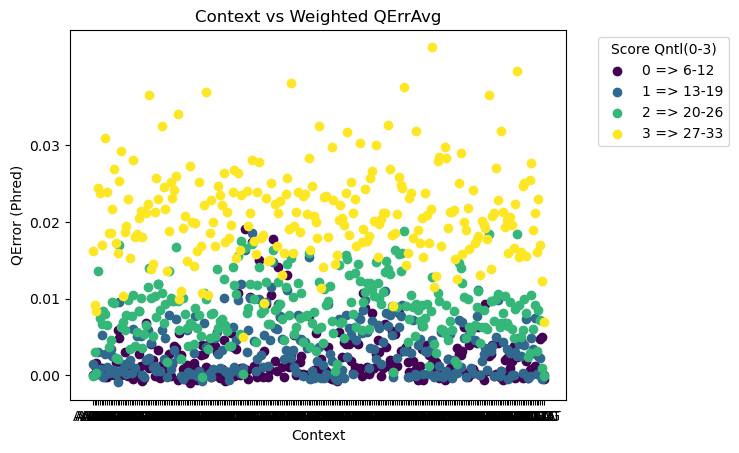

In [39]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from constants import RC_TAB2,RT2_STAT, CNTXT_RT2, RANGES
# draw a dot chart using matplotlib

def score_qntl_ranges(rt2_pre_stat_df):
    df =  rt2_pre_stat_df.groupby(RC_TAB2.RG_SCORE_BIN_COL)[RC_TAB2.QLTY_SCORE_COL].apply(lambda x: (min(x), max(x))).reset_index()
    return df.rename(columns={RC_TAB2.QLTY_SCORE_COL: RANGES.SCORE_BIN})

def jitter_list(lst, mean=0, std=0.1):
    jittered_list = np.array(lst) + np.random.normal(mean, std, len(lst))
    return jittered_list.tolist()


y_start, y_end = cntxt_rt2_stat_df[RT2_STAT.QLTY_ERR_W_AVG_COL].min(), 0.04
jitter_factor = (y_end - y_start) /100

ranges = score_qntl_ranges(rt2_pre_stat_df)[RANGES.SCORE_BIN].unique()
cmap = cm.get_cmap('viridis', len(cntxt_rt2_stat_df[RC_TAB2.RG_SCORE_BIN_COL].unique()))
# create the scatter plot
fig, ax = plt.subplots()
for i, group in cntxt_rt2_stat_df.groupby(RC_TAB2.RG_SCORE_BIN_COL):
    jittered_y = jitter_list(group[RT2_STAT.QLTY_ERR_W_AVG_COL], 0 , jitter_factor)
    # ax.scatter(group[CNTXT_RT2.CNTXT_COL], group[RT2_STAT.QLTY_ERR_W_AVG_COL], 
    ax.scatter(group[CNTXT_RT2.CNTXT_COL], jittered_y, 
            #    c=[cmap(i)], label=i)
        c=[cmap(i)], label=f'{i} => {ranges[i][0]}-{ranges[i][1]}')

ax.set_title('Context vs Weighted QErrAvg')
ax.set_xlabel('Context')
ax.set_ylabel('QError (Phred)')
ax.legend(title="Score Qntl(0-3)", bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.xticks(range(cyc_rt2_stat_df[CYC_RT2.CYC_BIN_COL].min(), cyc_rt2_stat_df[CYC_RT2.CYC_BIN_COL].max()+1,2))
Y_TICKS_COUNT = 5

import numpy as np
yticks = np.arange(y_start, y_end, (y_end - y_start) / (Y_TICKS_COUNT - 1))

plt.yticks(yticks)
# display the chart
plt.show()


QError Avg vs Contest

/tmp/ipykernel_1025150/636233247.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(cntxt_rt2_stat_df[RC_TAB2.RG_SCORE_BIN_COL].unique()))


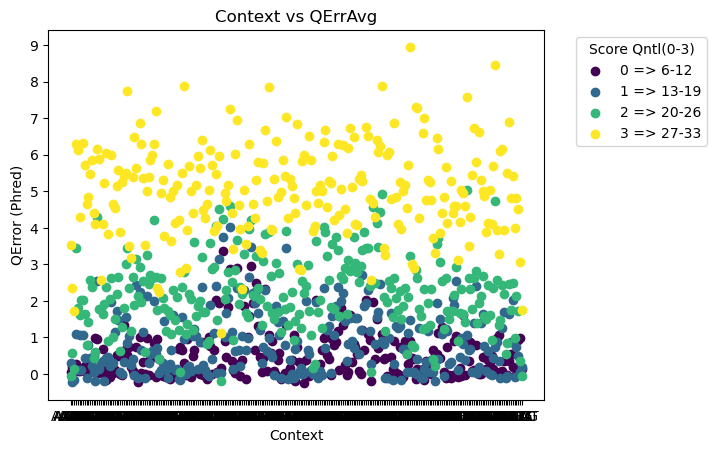

In [36]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from constants import RC_TAB2,RT2_STAT, CNTXT_RT2, RANGES
# draw a dot chart using matplotlib

def score_qntl_ranges(rt2_pre_stat_df):
    df =  rt2_pre_stat_df.groupby(RC_TAB2.RG_SCORE_BIN_COL)[RC_TAB2.QLTY_SCORE_COL].apply(lambda x: (min(x), max(x))).reset_index()
    return df.rename(columns={RC_TAB2.QLTY_SCORE_COL: RANGES.SCORE_BIN})

def jitter_list(lst, mean=0, std=0.1):
    jittered_list = np.array(lst) + np.random.normal(mean, std, len(lst))
    return jittered_list.tolist()

ranges = score_qntl_ranges(rt2_pre_stat_df)[RANGES.SCORE_BIN].unique()
cmap = cm.get_cmap('viridis', len(cntxt_rt2_stat_df[RC_TAB2.RG_SCORE_BIN_COL].unique()))
# create the scatter plot
fig, ax = plt.subplots()
for i, group in cntxt_rt2_stat_df.groupby(RC_TAB2.RG_SCORE_BIN_COL):
    jittered_y = jitter_list(group[RT2_STAT.QLTY_ERR_AVG_COL])
    # ax.scatter(group[CNTXT_RT2.CNTXT_COL], group[RT2_STAT.QLTY_ERR_AVG_COL], 
            #    c=[cmap(i)], label=i)
    ax.scatter(group[CNTXT_RT2.CNTXT_COL], jittered_y, 
        c=[cmap(i)], label=f'{i} => {ranges[i][0]}-{ranges[i][1]}')

ax.set_title('Context vs QErrAvg')
ax.set_xlabel('Context')
ax.set_ylabel('QError (Phred)')
ax.legend(title="Score Qntl(0-3)", bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.xticks(range(cyc_rt2_stat_df[CYC_RT2.CYC_BIN_COL].min(), cyc_rt2_stat_df[CYC_RT2.CYC_BIN_COL].max()+1,2))
plt.yticks(range(round(cntxt_rt2_stat_df[RT2_STAT.QLTY_ERR_AVG_COL].min()), round(cntxt_rt2_stat_df[RT2_STAT.QLTY_ERR_AVG_COL].max())+1))
# display the chart
plt.show()


In [18]:
from br_stat_profiler import prepare_stat_df
from constants import RC_TAB2
mode = RC_TAB2.CYC_COV
cyc_rt2_stat_df = prepare_stat_df(rt2_pre_stat_df, mode, adict)
cyc_rt2_stat_df

,ReadGroup,RG_ScoreBin,CycleBin,QErrAvg,RG_ScrBin_COV_N,RG_ScrBin_N,QErrWeightedAvg,ID
0,HVWKMCCXY,0,-10,0.180952,105,1944,0.009774,-10:0:CycleBin
20,HVWKMCCXY,1,-10,0.627273,110,2086,0.033078,-10:1:CycleBin
40,HVWKMCCXY,2,-10,2.151786,112,2101,0.114707,-10:2:CycleBin
60,HVWKMCCXY,3,-10,3.855422,83,1771,0.180689,-10:3:CycleBin
9,HVWKMCCXY,0,-1,0.842697,89,1944,0.038580,-1:0:CycleBin
...,...,...,...,...,...,...,...,...
77,HVWKMCCXY,3,8,3.788889,90,1771,0.192547,8:3:CycleBin
18,HVWKMCCXY,0,9,0.222222,90,1944,0.010288,9:0:CycleBin
38,HVWKMCCXY,1,9,0.171429,105,2086,0.008629,9:1:CycleBin
58,HVWKMCCXY,2,9,1.285714,105,2101,0.064255,9:2:CycleBin


QError Weighted Avg vs Read Cycle

/tmp/ipykernel_1025150/1129262097.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(cyc_rt2_stat_df[RC_TAB2.RG_SCORE_BIN_COL].unique()))


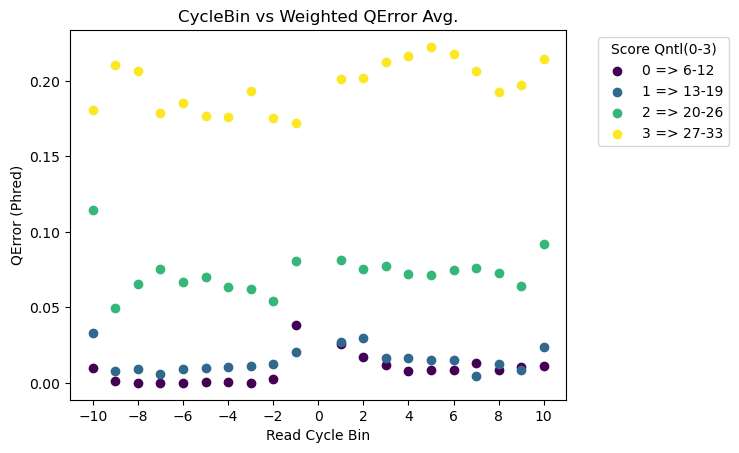

In [40]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from constants import RC_TAB2,RT2_STAT, CYC_RT2, RANGES
# draw a dot chart using matplotlib

def score_qntl_ranges(rt2_pre_stat_df):
    df =  rt2_pre_stat_df.groupby(RC_TAB2.RG_SCORE_BIN_COL)[RC_TAB2.QLTY_SCORE_COL].apply(lambda x: (min(x), max(x))).reset_index()
    return df.rename(columns={RC_TAB2.QLTY_SCORE_COL: RANGES.SCORE_BIN})

ranges = score_qntl_ranges(rt2_pre_stat_df)[RANGES.SCORE_BIN].unique()
cmap = cm.get_cmap('viridis', len(cyc_rt2_stat_df[RC_TAB2.RG_SCORE_BIN_COL].unique()))
# create the scatter plot
fig, ax = plt.subplots()
for i, group in cyc_rt2_stat_df.groupby(RC_TAB2.RG_SCORE_BIN_COL):
    ax.scatter(group[CYC_RT2.CYC_BIN_COL], group[RT2_STAT.QLTY_ERR_W_AVG_COL], 
            #    c=[cmap(i)], label=i)
        c=[cmap(i)], label=f'{i} => {ranges[i][0]}-{ranges[i][1]}')

ax.set_title('CycleBin vs Weighted QError Avg.')
ax.set_xlabel('Read Cycle Bin')
ax.set_ylabel('QError (Phred)')
ax.legend(title="Score Qntl(0-3)", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(range(cyc_rt2_stat_df[CYC_RT2.CYC_BIN_COL].min(), cyc_rt2_stat_df[CYC_RT2.CYC_BIN_COL].max()+1,2))
# plt.yticks(range(round(cyc_rt2_stat_df[RT2_STAT.QLTY_ERR_AVG_COL].min()), round(cyc_rt2_stat_df[RT2_STAT.QLTY_ERR_AVG_COL].max())+1))
# display the chart
plt.show()


/tmp/ipykernel_1025150/1224628917.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis', len(cyc_rt2_stat_df[RC_TAB2.RG_SCORE_BIN_COL].unique()))


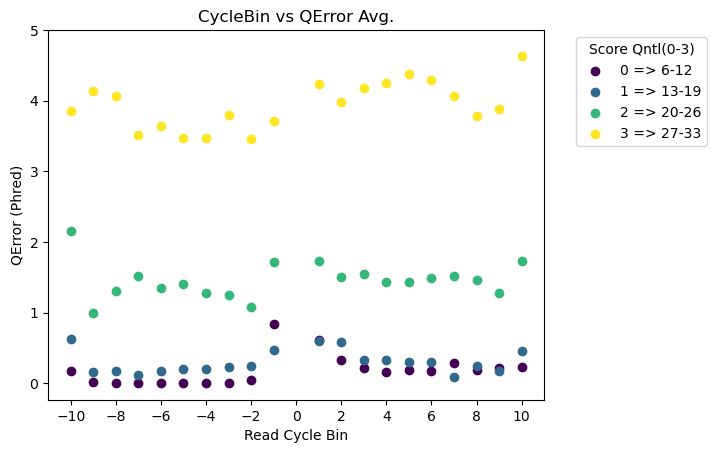

In [41]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from constants import RC_TAB2,RT2_STAT, CYC_RT2, RANGES
# draw a dot chart using matplotlib

def score_qntl_ranges(rt2_pre_stat_df):
    df =  rt2_pre_stat_df.groupby(RC_TAB2.RG_SCORE_BIN_COL)[RC_TAB2.QLTY_SCORE_COL].apply(lambda x: (min(x), max(x))).reset_index()
    return df.rename(columns={RC_TAB2.QLTY_SCORE_COL: RANGES.SCORE_BIN})

ranges = score_qntl_ranges(rt2_pre_stat_df)[RANGES.SCORE_BIN].unique()
cmap = cm.get_cmap('viridis', len(cyc_rt2_stat_df[RC_TAB2.RG_SCORE_BIN_COL].unique()))
# create the scatter plot
fig, ax = plt.subplots()
for i, group in cyc_rt2_stat_df.groupby(RC_TAB2.RG_SCORE_BIN_COL):
    ax.scatter(group[CYC_RT2.CYC_BIN_COL], group[RT2_STAT.QLTY_ERR_AVG_COL], 
            #    c=[cmap(i)], label=i)
        c=[cmap(i)], label=f'{i} => {ranges[i][0]}-{ranges[i][1]}')

ax.set_title('CycleBin vs QError Avg.')
ax.set_xlabel('Read Cycle Bin')
ax.set_ylabel('QError (Phred)')
ax.legend(title="Score Qntl(0-3)", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(range(cyc_rt2_stat_df[CYC_RT2.CYC_BIN_COL].min(), cyc_rt2_stat_df[CYC_RT2.CYC_BIN_COL].max()+1,2))
plt.yticks(range(round(cyc_rt2_stat_df[RT2_STAT.QLTY_ERR_AVG_COL].min()), round(cyc_rt2_stat_df[RT2_STAT.QLTY_ERR_AVG_COL].max())+1))
# display the chart
plt.show()
